# Stage 1. IR description - Turkey 3-month Bond Yield

**Made by** Vadim Smirnov and Vladislav Gusev

------------------------------

## Introduction:

Due to the unacessablility of the key interest rates in Turkey it was decided to replicate this indicator with the market rate. 10-year bonds in many countries could be considered representative on the current state of the economy, as well as forward-looking. Usually the 1-year yield is considered, but the 2-year is still pretty accurate in terms of the estimation of the short-term yield.

Due to the extreme inversion of the yield curve currently (10year - 2year spread is -1655 bp) and it is humped-shaped as the yields between 3 and 9 months are relatively lower to the 2-year yield. 

**Quoting and conventions:**

Day count basis: ACT/360 or 30E/360

Settlement, primary and secondary market (for International bonds as a benchmark): T+2

Coupon rate: 12.6%, semi-annual

**Those conventions are common for the majority of the European countries with the exception that usually bonds have annual coupons**

## Primary Analysis:

In [1]:
#!pip install tslearn
#!pip install threadpoolctl --upgrade
#!pip install numpy --upgrade
#!pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
import random

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\dguse\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dguse\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\dguse\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
random.seed(1337)

df = pd.read_csv("turk3myield.csv")
df["Date"] =pd.to_datetime(df["Date"])
df["Price"] = df["Price"] * 0.01
df = df.sort_values(by='Date')
df.index = df["Date"]
X = df['Price'].values.reshape(-1,1)
df.head()

,Date,Price,Open,High,Low,Change %
Date,,,,,,
2000-01-05,2000-01-05,0.4071,40.71,40.71,40.71,-21.92%
2000-01-19,2000-01-19,0.3301,33.01,33.01,33.01,-18.91%
2000-01-20,2000-01-20,0.3365,33.65,33.65,33.65,1.94%
2000-01-21,2000-01-21,0.3358,33.58,33.58,33.58,-0.21%
2000-01-24,2000-01-24,0.3367,33.67,33.67,33.67,0.27%


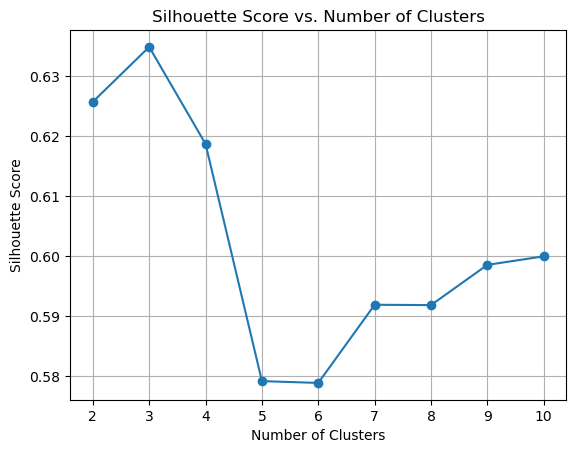

In [4]:
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in cluster_range:
    # Fit K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores vs. number of clusters
import matplotlib.pyplot as plt

plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

**Choosing 3 clusters with the best score**

In [5]:
# Clustering (using K-means)
n_clusters = 3  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(X.reshape(-1,1))

# Print cluster centers and labels
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("Cluster Labels:")
print(cluster_labels)

Cluster Centers:
[[0.17828957]
 [0.09231082]
 [0.37023801]]
Cluster Labels:
[2 2 2 ... 2 2 2]


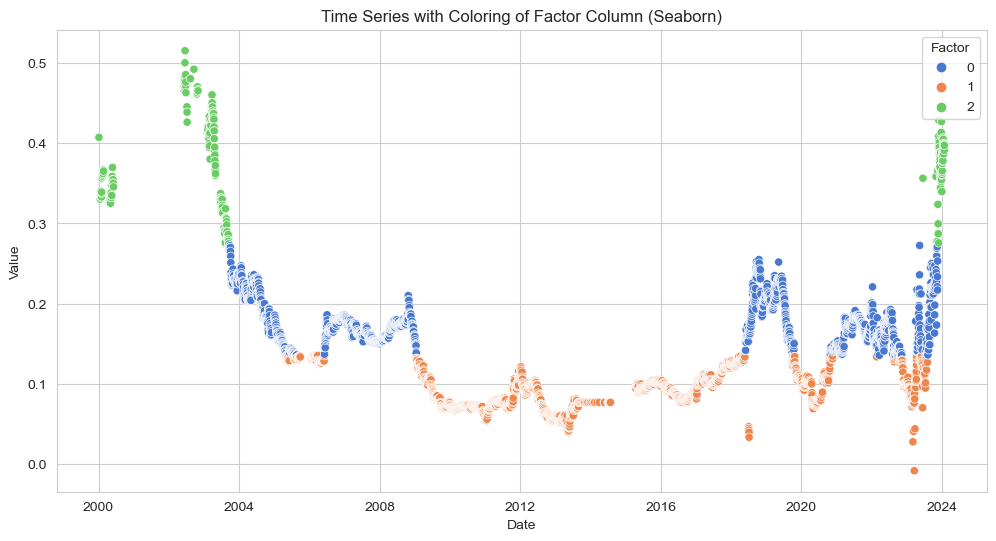

In [6]:
df['Cluster'] = cluster_labels

sns.set_style("whitegrid")

# Plot time series with coloring based on the 'factor' column using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Date', y='Price', hue='Cluster', data=df, palette='muted')
plt.title('Time Series with Coloring of Factor Column (Seaborn)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Factor')
plt.show()

## Qualitative Conclusions:

There were sevelral critical periods in Turkish economy, namely global economic crisis - its beginning and the aftermath; period between 2018 and 2019 - economic crisis; economic instability in 2021-2022 due to Ukranian crisis and the most recent rise in short term interst rates as the govenment tries to fight the neverending inflation.

Turkish economy is one of the most interesting relatively developed countries with massive market return volatility.

# Stage 2. IR Modelling - Turkey 3-month Bond Yield

#### Working with AR

In [7]:
for i in range(1, 4):
    df[f'Lag_{i}'] = df['Price'].shift(i)

In [8]:
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]
train_y = train_df['Price']
test_y = test_df['Price']

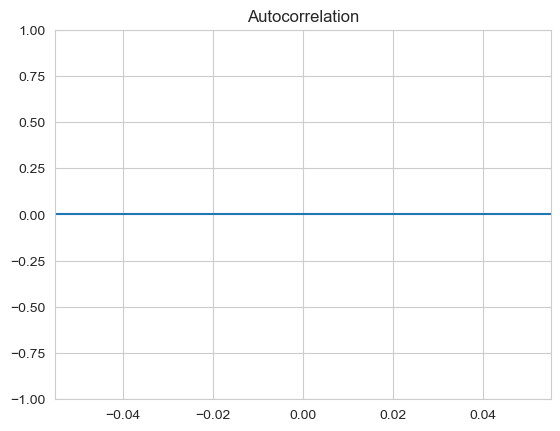

In [9]:
series = df['Price'] - df['Lag_1']
plot_acf(series)
plt.show()

In [ ]:
ar_model = AutoReg(train_y, lags=1)
ar_results = ar_model.fit()

  
y_pred = ar_results.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, dynamic=False)
 
# Calculate MAE and RMSE
mae = mean_absolute_error(test_y, y_pred)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index,train_y, label='Past Rates')
plt.plot(test_df.index,test_y, label='Actual Rates')
plt.plot(test_df.index,y_pred, label='Predicted Rates', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
plt.title('Rates Prediction with AR')
plt.show()

In [ ]:
lamb_test = (1- ar_results.params.iloc[1]) / (1/252)
mu_test = ar_results.params.iloc[0]/(1- ar_results.params.iloc[1])

In [ ]:
forecast_steps = 365
 
# Extend the predictions into the future for one year
future_indices = range(len(test_df), len(test_df) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_df), end=len(train_df) + len(test_df) + forecast_steps - 1, dynamic=True)
 
# Create date indices for the future predictions
future_dates = pd.date_range(start=test_df['Date'].iloc[-1], periods=forecast_steps, freq='D')
 
# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_y, label='Actual Rates')
plt.plot(test_df['Date'], y_pred, label='Predicted Rates', linestyle='--')
plt.plot(future_dates, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
plt.title('Rates Prediction with AR')
plt.show()

In [ ]:
ar_results.params

### Construction of Vasicek model

In [ ]:
from scipy.optimize import fmin
import matplotlib.markers as mk
import matplotlib.ticker as mtick

As the data we analyze is daily, the variable delta t is equal to 1 

In [ ]:
lamb = (1- ar_results.params.iloc[1]) / (1/252)
mu = ar_results.params.iloc[0]/(1- ar_results.params.iloc[1])

#### Collecting data on the yield curve from the webiste http://www.worldgovernmentbonds.com/country/turkey/

In [ ]:
termstruc = pd.DataFrame()
termstruc['Maturity'] = [3/12, 6/12, 9/12, 2, 3, 5, 10]
termstruc['Yield'] = np.array([39.866, 39.068, 38.755, 43.675, 32.180, 32.365, 27.285])*0.01
plt.plot(termstruc["Maturity"], termstruc['Yield'])
None

#### Interpolating using NSS algorithm

In [ ]:
b = pd.DataFrame({"Maturity": np.arange(0,30.05,(1/252))})
df = pd.merge(left = b, right = termstruc, how = "left", on = "Maturity")
dd = df.copy()

In [ ]:
β0 = 0.01
β1 = 0.01
β2 = 0.01
β3 = 0.01
λ0 = 1.00
λ1 = 1.00

In [ ]:
df['NSS'] = (β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))-(np.exp(-df['Maturity']/λ0))))+(β3*((((1-np.exp(-df['Maturity']/λ1))/(df['Maturity']/λ1)))-(np.exp(-df['Maturity']/λ1))))
df['Residual'] =  (df['Yield'] - df['NSS'])**2

In [ ]:
def myval(c):
    df = dd.copy()
    df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']/c[4]))/(df['Maturity']/c[4])))+(c[2]*((((1-np.exp(-df['Maturity']/c[4]))/(df['Maturity']/c[4])))-(np.exp(-df['Maturity']/c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']/c[5]))/(df['Maturity']/c[5])))-(np.exp(-df['Maturity']/c[5]))))
    df['Residual'] =  (df['Yield'] - df['NSS'])**2
    val = np.sum(df['Residual'])
    print("[β0, β1, β2, β3, λ0, λ1]=",c,", SUM:", val)
    return(val)

c = fmin(myval, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])

In [ ]:
β0 = c[0]
β1 = c[1]
β2 = c[2]
β3 = c[3]
λ0 = c[4]
λ1 = c[5]
print("[β0, β1, β2, β3, λ0, λ1]=", [c[0].round(2), c[1].round(2), c[2].round(2), c[3].round(2), c[4].round(2), c[5].round(2)])

In [ ]:
df = dd.copy()
df['NSS'] =(β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))-(np.exp(-df['Maturity']/λ0))))+(β3*((((1-np.exp(-df['Maturity']/λ1))/(df['Maturity']/λ1)))-(np.exp(-df['Maturity']/λ1))))
fontsize=15
plt.figure(figsize=(13,7))
plt.scatter(df['Maturity'], df['NSS'], color="orange", label="NSS")
plt.scatter(dd['Maturity'], dd['Yield'], marker="o", c="blue")
plt.xlabel('Period',fontsize=fontsize)
plt.ylabel('Interest',fontsize=fontsize)
plt.title("Nelson-Siegel-Svensson Model - Fitted Yield Curve",fontsize=fontsize)
plt.grid()
plt.show()

#### Calculating discount factors

In [ ]:
df['Discount'] = np.exp(-df['NSS'] * df['Maturity'])
plt.plot(df["Maturity"], df['Discount'])
None

#### Calculating instantenious forward rates

In [ ]:
df['Forward'] = -(1/(1/252)) * np.log(df['Discount'].shift(-1)/df['Discount'])

In [ ]:
plt.plot(df["Maturity"], df['Forward'])
plt.plot(df["Maturity"], df['NSS'])
None

In [ ]:
df['Forward Derivative'] = (df['Forward'].shift(-1) - df['Forward'])/(1/252)

df_old = pd.read_csv("turk3myield.csv")
df_old["Date"] =pd.to_datetime(df_old ["Date"])
df_old = df_old.sort_values(by='Date')
df_old = df_old.reset_index()

### Calculating necessary variables to simulate Vasicek

#sigma on full sample, as well as parameters for the model that predicts 365 in the future (using full sample)
sigma = np.std(df_old["Price"] * 0.01) * np.sqrt(252)
kappa = lamb
theta = lamb * mu

Hull-White:

$$
\mathrm{d}r(t) = (\theta(t)-\kappa r(t))\mathrm{d}t+\sigma\mathrm{d}W(t)
$$

Vasicek:

$$
\mathrm{d}r(t) = (\theta-\kappa r(t))\mathrm{d}t+\sigma\mathrm{d}W(t)
$$

### Calculating theta for the Hull-White Simulations

#### 1. For the future forecast (from the current day)

In [ ]:
df['Theta'] = df['Forward Derivative'] + kappa * df['Forward'] + (sigma**2 / (2*kappa))*(1 - np.exp(-2*kappa * df["Maturity"]))
df['Theta']  = df['Theta'].interpolate(method='linear', limit_direction='both')

#### 2. For the in-sample simulations - we have to find the yield curve for the January of 2021

How can we do it? Simply find historical yields (closing) on Turkish treasutries (3,6,9-month, 2,3,5,10-year) at time 1st of January 2021 from the investing.com

In [ ]:
termstruc = pd.DataFrame()
termstruc['Maturity'] = [3/12, 6/12, 9/12, 2, 3, 5, 10]
termstruc['Yield'] = np.array([14.227, 14.766, 15.289, 14.25, 13.64, 12.93, 12.57])*0.01

β0 = 0.01
β1 = 0.01
β2 = 0.01
β3 = 0.01
λ0 = 1.00
λ1 = 1.00

b = pd.DataFrame({"Maturity": np.arange(0,10.05,(1/252))})
df1 = pd.merge(left = b, right = termstruc, how = "left", on = "Maturity")
dd = df1.copy()
df1['NSS'] = (β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df1['Maturity']/λ0))/(df1['Maturity']/λ0)))-(np.exp(-df1['Maturity']/λ0))))+(β3*((((1-np.exp(-df1['Maturity']/λ1))/(df1['Maturity']/λ1)))-(np.exp(-df1['Maturity']/λ1))))
df1['Residual'] =  (df1['Yield'] - df1['NSS'])**2

In [ ]:
def myval(c):
    df1 = dd.copy()
    df1['NSS'] =(c[0])+(c[1]*((1-np.exp(-df1['Maturity']/c[4]))/(df1['Maturity']/c[4])))+(c[2]*((((1-np.exp(-df1['Maturity']/c[4]))/(df1['Maturity']/c[4])))-(np.exp(-df1['Maturity']/c[4]))))+(c[3]*((((1-np.exp(-df1['Maturity']/c[5]))/(df1['Maturity']/c[5])))-(np.exp(-df1['Maturity']/c[5]))))
    df1['Residual'] =  (df1['Yield'] - df1['NSS'])**2
    val = np.sum(df1['Residual'])
    print("[β0, β1, β2, β3, λ0, λ1]=",c,", SUM:", val)
    return(val)

c = fmin(myval, [0.1, 0.1, 0.1, 0.1, 1.00, 1.00])

In [ ]:
df1 = dd.copy()
β0 = c[0]
β1 = c[1]
β2 = c[2]
β3 = c[3]
λ0 = c[4]
λ1 = c[5]

df1['NSS'] =(β0)+(β1*((1-np.exp(-df1['Maturity']/λ0))/(df1['Maturity']/λ0)))+(β2*((((1-np.exp(-df1['Maturity']/λ0))/(df1['Maturity']/λ0)))-(np.exp(-df1['Maturity']/λ0))))+(β3*((((1-np.exp(-df1['Maturity']/λ1))/(df1['Maturity']/λ1)))-(np.exp(-df1['Maturity']/λ1))))
fontsize=15
plt.figure(figsize=(13,7))
plt.scatter(df1['Maturity'], df1['NSS'], color="orange", label="NSS")
plt.scatter(dd['Maturity'], dd['Yield'], marker="o", c="blue")
plt.xlabel('Period',fontsize=fontsize)
plt.ylabel('Interest',fontsize=fontsize)
plt.title("Nelson-Siegel-Svensson Model - Fitted Yield Curve",fontsize=fontsize)
plt.grid()
plt.show()

In [ ]:
df1['Discount'] = np.exp(-df1['NSS'] * df1['Maturity'])
df1['Forward'] = -(1/(1/252)) * np.log(df1['Discount'].shift(-1)/df1['Discount'])

In [ ]:
### Plotting forward and spot rates
plt.plot(df1["Maturity"], df1['Forward'])
plt.plot(df1["Maturity"], df1['NSS'])
None

In [ ]:
df1['Forward Derivative'] = (df1['Forward'].shift(-1) - df1['Forward'])/(1/252)
kappa = lamb_test
### sigma on train
sigma = np.std(df_old["Price"].iloc[:4000] * 0.01) * np.sqrt(252)
df1['Theta'] = df1['Forward Derivative'] + kappa * df1['Forward'] + (sigma**2 / (2*kappa))*(1 - np.exp(-2*kappa * df1["Maturity"]))
df1['Theta']  = df1['Theta'].interpolate(method='linear', limit_direction='both')

## Vasicek Simulation (Backtest)

### We simulate in 1000 observations in the past. Namely, from the beginning of 2021 to the beginning of 2024

In [ ]:
def vasicek(r0, kappa, theta, sigma, T, dt, n_paths):
    """
    Simulate interest rates using the Vasicek model.

    Parameters:
        r0 (float): Initial interest rate.
        kappa (float): Mean-reversion rate.
        theta (float): Long-term mean of the interest rate.
        sigma (float): Volatility of the interest rate.
        T (float): Time horizon.
        dt (float): Time step size.
        n_paths (int): Number of simulation paths.

    Returns:
        numpy.ndarray: Simulated interest rate paths.
    """
    np.random.seed(1337)
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        rates[:, i] = rates[:, i - 1] + kappa * (theta -  rates[:, i - 1]) * dt + sigma * np.sqrt(dt) * dW

    return rates

In [ ]:
train_size = int(0.8 * len(df_old))
train_df = df_old[:train_size]
test_df = df_old[train_size:]
train_y = train_df['Price'] * 0.01
test_y = test_df['Price'] * 0.01

In [ ]:
lamb_test

In [ ]:
# Parameters
r0 = train_y.iloc[-1]  # Initial interest rate
kappa = lamb  # Mean-reversion rate
theta = lamb * mu  # Long-term mean of the interest rate
sigma = np.std(df_old["Price"].iloc[:4000] * 0.01) * np.sqrt(252)  # Volatility of the interest rate
T = 50  # Time horizon
dt = 0.05 # Time step size (daily steps)
n_paths = 10  # Number of simulation paths

# Simulate interest rates
interest_rates = vasicek(r0, lamb_test, mu_test, sigma, T, dt, n_paths)

# Plot simulation results
plt.figure(figsize=(10, 6))
#plt.plot(train_df.index,train_y, label='Past Rates')
plt.plot(test_df.index,test_y, label='Actual Rates')
plt.plot(test_df.index, interest_rates.T, linestyle='--', alpha = 0.4)
plt.title('Simulated Vasicek Interest Rate Paths, Test Sample')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

### Calculating RMSE on test sample

In [ ]:
squared_diff = (np.tile(test_y, (10, 1)) - interest_rates)**2
mean_squared_diff = np.mean(squared_diff, axis=0)
rmse = np.sqrt(mean_squared_diff)
plt.hist(rmse)
None

In [ ]:
np.mean(rmse)

## Hull-White Simulation (Backtest)

### We simulate in 1000 observations in the past. Namely, from the beginning of 2021 to the beginning of 2024

In [ ]:
def hullwhite(r0, kappa, theta, sigma, T, dt, n_paths):
    """
    Simulate interest rates using the Vasicek model.

    Parameters:
        r0 (float): Initial interest rate.
        kappa (float): Mean-reversion rate.
        theta (array): Long-term mean of the interest rate.
        sigma (float): Volatility of the interest rate.
        T (float): Time horizon.
        dt (float): Time step size.
        n_paths (int): Number of simulation paths.

    Returns:
        numpy.ndarray: Simulated interest rate paths.
    """
    np.random.seed(1337)
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        rates[:, i] = rates[:, i - 1] + (theta[i-1] - kappa * rates[:, i - 1]) * dt + sigma * np.sqrt(dt) * dW

    return rates

In [ ]:
# Parameters
r0 = train_y.iloc[-1]  # Initial interest rate
kappa = lamb_test  # Mean-reversion rate
theta_array = df1['Theta'].values  # Example array for theta
sigma = np.std(df_old["Price"].iloc[:4000] * 0.01) * np.sqrt(252) # Volatility of the interest rate
T = 50  # Time at which to simulate the interest rate
dt = 0.05  # Time step size
n_paths = 10
# Simulate interest rate
interest_rate = hullwhite(r0, kappa, theta_array, sigma, T, dt, n_paths)

# Plot simulation results
plt.figure(figsize=(10, 6))
#plt.plot(train_df.index,train_y, label='Past Rates')
plt.plot(test_df.index,test_y, label='Actual Rates')
plt.plot(test_df.index, interest_rate.T, linestyle='--', alpha = 0.4)
plt.title('Simulated Hull-White Interest Rate Paths, Test Sample')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

In [ ]:
squared_diff = (np.tile(test_y, (10, 1)) - interest_rate)**2
mean_squared_diff = np.mean(squared_diff, axis=0)
rmse = np.sqrt(mean_squared_diff)
plt.hist(rmse)
None

In [ ]:
np.mean(rmse)

# Out-of sample simulations for both models

In [ ]:
r0 = test_y.iloc[-1]
kappa = lamb
theta = mu
theta_array = df['Theta'].values
sigma = np.std(df_old["Price"] * 0.01) * np.sqrt(252)
T = 1
dt = 1/252
n_paths = 5

forecast_steps = 252
future_indices = range(len(test_df), len(test_df) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_df), end=len(train_df) + len(test_df) + forecast_steps - 1, dynamic=True)
future_dates = pd.date_range(start=test_df['Date'].iloc[-1], periods=forecast_steps, freq='D')

interest_rate = hullwhite(r0, kappa, theta_array, sigma, T, dt, n_paths)
interest_rates = vasicek(r0, kappa, theta, sigma, T, dt, n_paths)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'],train_y, label='Past Rates', color = "blue")
plt.plot(test_df['Date'],test_y, label='Actual Rates', color = "green")
plt.plot(future_dates, interest_rate.T, linestyle='--', alpha = 0.4, color = "red", label = "Hull-White")
plt.plot(future_dates, interest_rates.T, linestyle='--', alpha = 0.4, color = "orange", label = "Vasicek")
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
plt.title('Rates Prediction with stochastic models')
plt.show()

# Stage 3. IR Modelling - Turkey 3-month Bond Yield

As the Vasicek model gave the best RMSE on the test sample, it is safe to assume that the forecast using this model will be the most reliable out of all the options: AR, Hull-White, Vasicek. 

As the model implies mean-reversion and current interest rates are unreasonably high, it is expected that contractionary monetary policy will take place or simply the uncertainty in the economy will decrease. 

In [ ]:
plt.plot(df["Maturity"], df['Forward'])
plt.plot(df["Maturity"], df['NSS'])
None

Currently the yield curve is significantly inverse and in addition forward rates are even lower (due to negative slope of the yield curve - derived from the formula)